The purpose of this notebook is to quickly model how the water potential varies up the trunk, assumig a single non-branching trunk.

In [1]:
from profit_optimisation_model.src.HydraulicConductanceModels.cumulative_Weibull_distribution_model import cumulative_Weibull_distribution
from profit_optimisation_model.src.HydraulicConductanceModels.cumulative_Weibull_distribution_model import cumulative_Weibull_distribution_parameters_from_conductance_loss

import numpy as np
from matplotlib import pyplot as plt
import copy as cp

# Model setup
First let us set up the properties of the system and the different arrays needed to hold the data.

In [2]:
p50 = -3.
p88 = -4.
k_max = 1.

# Calcualte the shape and scale parameters for the Weibull distribution
k_max, shape, scale = cumulative_Weibull_distribution_parameters_from_conductance_loss(k_max, p50, p88, 0.5, 0.88)

N_points = 1000

# Set up an array to hold the height of each point
hights = np.linspace(0, 100, N_points + 2)


# Model run
The transpiration across any given section must be constant through the system.

$$
E_{n, n+1} = k_{n, n+1} (\psi_{n+1} - \psi_{n})
$$

For suficently small $\Delta \psi$ we can approximate the conductance $k_{n, n+1}$ as the conductance at the mean of the two water potentials.

$$
k_{n, n+1} = k(\text{mean}(\psi_{n}, \psi_{n+1}))
$$

Given that the transpiration is equal for all sections we can write the following;

$$
k_{n, n+1}( \psi_{n+1} - \psi_{n}) = k_{n-1, n}( \psi_{n} - \psi_{n-1})
$$

Re-arranging the equation we get a value for the water potential at point $n$;

$$
\psi_{n} = \frac{\psi_{n-1}k_{n-1,n} + \psi_{n+1}k_{n,n+1}}{k_{n-1,n} + k_{n,n+1}}
$$

We can iteratively solve for the water potential and the conductance, holding the soil and lea water potentials at each end constant, until we reach equilibrium. This should give us the water potential at each point along the trunk.

In [3]:
def calc_height_dependencies(psi_root, psi_leaf, N_points, k_max, shape, scale, 
                             N_steps=1000000, tolerance=1e-8):
    
    psi_current = np.linspace(psi_root, psi_leaf, N_points + 2)

    psi_means_for_k = (psi_current[1:] + psi_current[:-1]) / 2
    k_current = cumulative_Weibull_distribution(psi_means_for_k, k_max, shape, scale)
    
    E_current = k_current * (psi_current[1:] - psi_current[:-1])
    
    i = 0
    
    for i in range(N_steps):
        # Update the water potential at each point
        psi_current[1:-1] = (psi_current[:-2] * k_current[:-1] + psi_current[2:] * k_current[1:]) / (k_current[:-1] + k_current[1:])
        
        # Update the conductance between each point
        psi_means_for_k = (psi_current[1:] + psi_current[:-1]) / 2
        k_current = cumulative_Weibull_distribution(psi_means_for_k, k_max, shape, scale)
        
        # Update the transpiration between each point
        E_current = k_current * (psi_current[1:] - psi_current[:-1])
        
        # Check for convergence
        if np.all(np.abs(E_current[0] - E_current[-1]) < tolerance):
            break
            
    
    print('Finished at step', i, 'of', N_steps)
    
    return psi_current, k_current, E_current

psi_leaf = -6.
psi_root = -0.1

psi, k, E = calc_height_dependencies(psi_root, 
                                                             psi_leaf, 
                                                             N_points, 
                                                             k_max, 
                                                             shape, 
                                                             scale)

Finished at step 999999 of 1000000


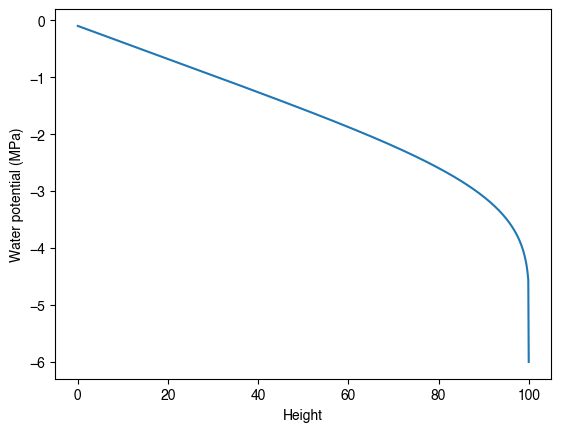

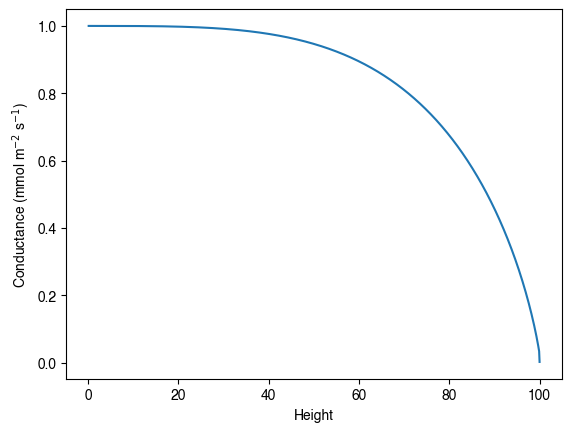

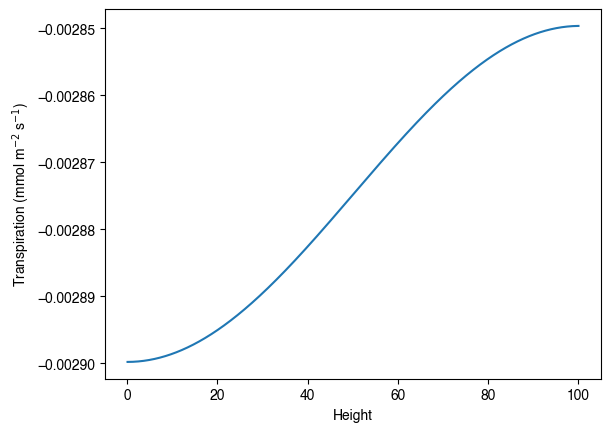

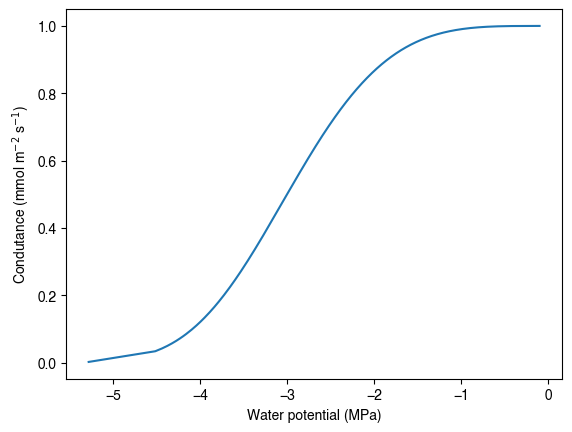

In [4]:
plt.plot(hights, psi)
plt.xlabel('Height')
plt.ylabel('Water potential (MPa)')
plt.show()

plt.plot(hights[1:], k)
plt.xlabel('Height')
plt.ylabel('Conductance (mmol m$^{-2}$ s$^{-1}$)')
plt.show()

plt.plot(hights[1:], E)
plt.xlabel('Height')
plt.ylabel('Transpiration (mmol m$^{-2}$ s$^{-1}$)')
plt.show()

plt.plot((psi[1:] + psi[:-1])/2, k)
plt.xlabel('Water potential (MPa)')
plt.ylabel('Condutance (mmol m$^{-2}$ s$^{-1}$)')
plt.show()

# Comparing different leaf water potentials

In [5]:
psi_leaf = [-1., -2., -3., -4., -5., -6.]

psi = []
k = []
E = []

for psi_leaf_current in psi_leaf:
    psi_current, k_current, E_current = calc_height_dependencies(psi_root, 
                                                                 psi_leaf_current, 
                                                                 N_points, 
                                                                 k_max, 
                                                                 shape, 
                                                                 scale)
    psi.append(psi_current)
    k.append(k_current)
    E.append(E_current)
    


Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000


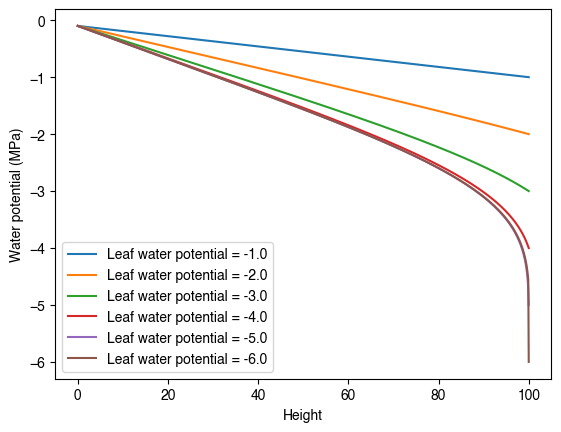

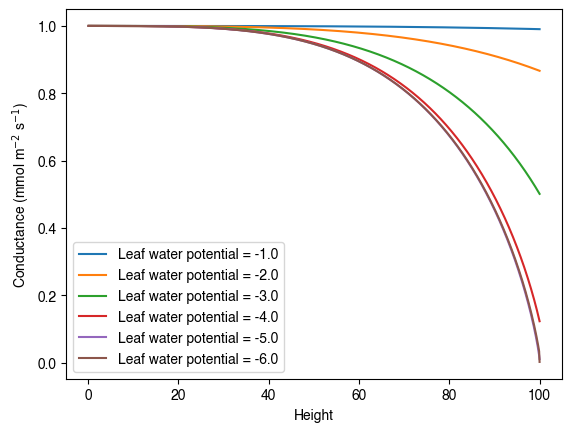

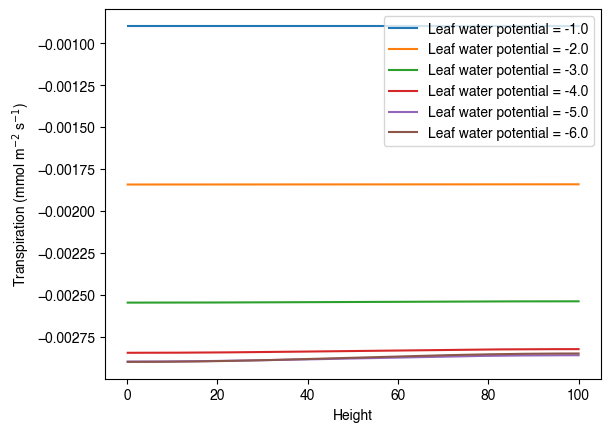

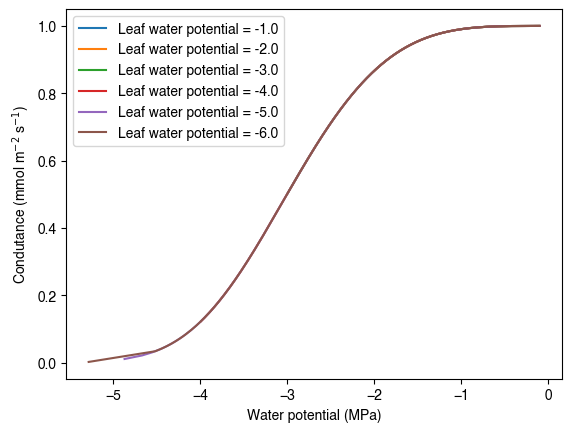

In [6]:
for i in range(len(psi)):
    plt.plot(hights, psi[i], label='Leaf water potential = ' + str(psi_leaf[i]))
plt.xlabel('Height')
plt.ylabel('Water potential (MPa)')
plt.legend()
plt.show()

for i in range(len(k)):
    plt.plot(hights[1:], k[i], label='Leaf water potential = ' + str(psi_leaf[i]))
plt.xlabel('Height')
plt.ylabel('Conductance (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()

for i in range(len(E)):
    plt.plot(hights[1:], E[i], label='Leaf water potential = ' + str(psi_leaf[i]))
plt.xlabel('Height')
plt.ylabel('Transpiration (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()

for i in range(len(E)):
    plt.plot((psi[i][1:]+psi[i][:-1])/2, k[i], label='Leaf water potential = ' + str(psi_leaf[i]))
plt.xlabel('Water potential (MPa)')
plt.ylabel('Condutance (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()

# Capping the conductance

Let's repeat the experiment above but, we cap the conductance at each height to the value reached when the leaf water potential was -3.0 MPa. This is done to mimic the effect of cavitation in the system limiting conductance at each height to the previous minimum value.

In [7]:
def calc_height_dependencies_capped_k(psi_root, psi_leaf, N_points, k_max, shape, scale, k_cap,
                                      N_steps=1000000, tolerance=1e-8):
    
    psi_current = np.linspace(psi_root, psi_leaf, N_points + 2)

    psi_means_for_k = (psi_current[1:] + psi_current[:-1]) / 2
    k_current = cumulative_Weibull_distribution(psi_means_for_k, k_max, shape, scale)
    
    E_current = k_current * (psi_current[1:] - psi_current[:-1])
    
    i = 0
    
    for i in range(N_steps):
        # Update the water potential at each point
        psi_current[1:-1] = (psi_current[:-2] * k_current[:-1] + psi_current[2:] * k_current[1:]) / (k_current[:-1] + k_current[1:])
        
        # Update the conductance between each point
        psi_means_for_k = (psi_current[1:] + psi_current[:-1]) / 2
        k_current = cumulative_Weibull_distribution(psi_means_for_k, k_max, shape, scale)
        
        # Cap the conductance
        k_current = np.minimum(k_current, k_cap)
        
        # Calculate the transpiration between each point
        E_current = k_current * (psi_current[1:] - psi_current[:-1])
        
        # Check for convergence
        if np.all(np.abs(E_current[0] - E_current[-1]) < tolerance):
            break
            
    
    print('Finished at step', i, 'of', N_steps)
    
    return psi_current, k_current, E_current

In [8]:
# Cap the conductance for each height as the value when the leaf water potential is -3.0 MPa
k_cap = cp.copy(k[2])

psi_leaf = [-1., -1.5, -2., -2.5, -3., -4., -5., -6.]

psi = []
k = []
E = []

for psi_leaf_current in psi_leaf:
    psi_current, k_current, E_current = calc_height_dependencies_capped_k(psi_root, 
                                                                          psi_leaf_current, 
                                                                          N_points, 
                                                                          k_max, 
                                                                          shape, 
                                                                          scale,
                                                                          k_cap)
    psi.append(psi_current)
    k.append(k_current)
    E.append(E_current)
    


Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000


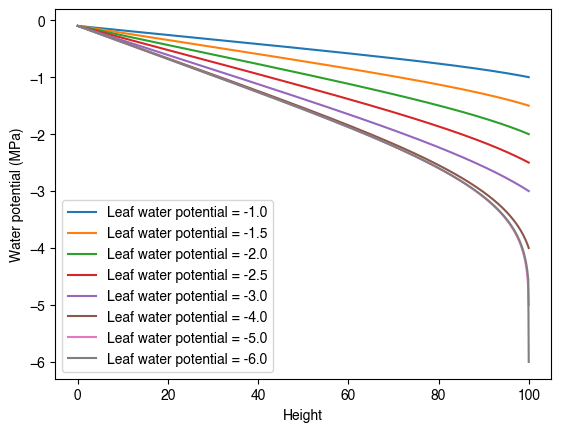

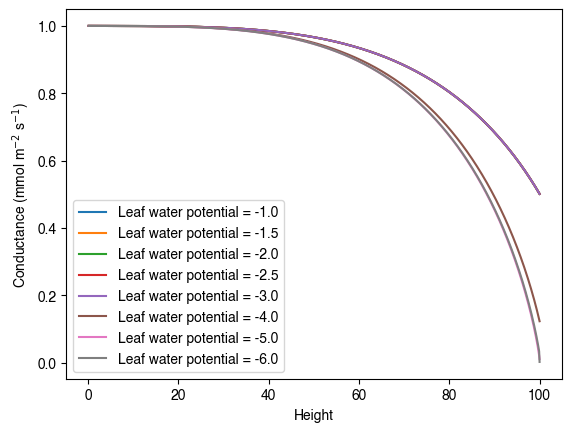

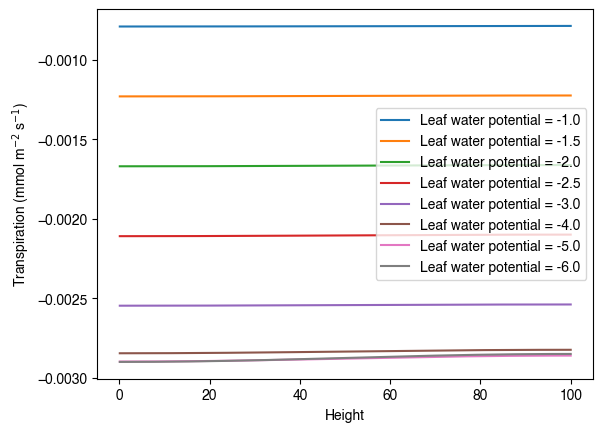

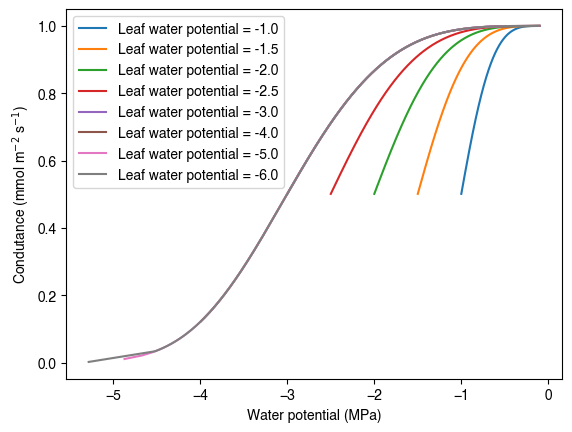

In [9]:
for i in range(len(psi)):
    plt.plot(hights, psi[i], label='Leaf water potential = ' + str(psi_leaf[i]))
plt.xlabel('Height')
plt.ylabel('Water potential (MPa)')
plt.legend()
plt.show()

for i in range(len(k)):
    plt.plot(hights[1:], k[i], label='Leaf water potential = ' + str(psi_leaf[i]))
plt.xlabel('Height')
plt.ylabel('Conductance (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()

for i in range(len(E)):
    plt.plot(hights[1:], E[i], label='Leaf water potential = ' + str(psi_leaf[i]))
plt.xlabel('Height')
plt.ylabel('Transpiration (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()

for i in range(len(E)):
    plt.plot((psi[i][1:]+psi[i][:-1])/2, k[i], label='Leaf water potential = ' + str(psi_leaf[i]))
plt.xlabel('Water potential (MPa)')
plt.ylabel('Condutance (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()